In [2]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_csv('../data/raw_spoken.txt', header=None, delimiter='\t') #500k  (499998)
df2 = pd.read_csv('../data/raw_ratings.txt', header=None, delimiter='\t') #200k (199992)
df3 = pd.read_csv('../data/raw_wiki_ko_sent.txt', header=None, delimiter='\t') #4M (4528804)

## 1. Basic Corpus Stat

In [11]:
print("Number of Sentences")
print(len(df1))
print(len(df2))
print(len(df3))

df1['length'] = df1[0].apply(len)
df2['length'] = df2[0].apply(len)
df3['length'] = df3[0].apply(len)

print("\n==Basic Stat==")
print(df1['length'].mean(), df1['length'].median(), df1['length'].std())
print(df2['length'].mean(), df2['length'].median(), df2['length'].std())
print(df3['length'].mean(), df3['length'].median(), df3['length'].std())

print("\n==Total Character==")
print(df1['length'].sum())
print(df2['length'].sum())
print(df3['length'].sum())



Number of Sentences
499998
199992
4497439

==Basic Stat==
29.40379361517446 27.0 10.407786762837393
35.21584363374535 27.0 29.539721650199972
100.6422975386659 58.0 384.1223717329612

==Total Character==
14701838
7042887
452632594


AxesSubplot(0.125,0.125;0.775x0.755)


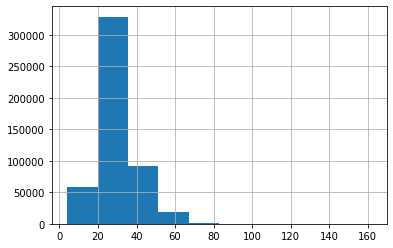

In [5]:
print(df1['length'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


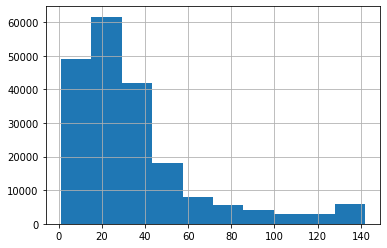

In [6]:
print(df2['length'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


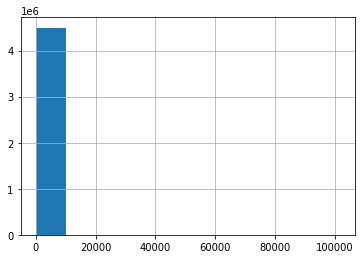

In [7]:
print(df3['length'].hist())

In [8]:
print(df3['length'].max())

101856


## Preprocess2. Remain only Korean/Special Characters  

[Ref1] : https://data-newbie.tistory.com/210  
[Ref2] : 

In [83]:
import re

def clean_str(text):

    #print("Original Sentence:", text)

    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern=pattern, repl='', string=text)
    #print("Email removed:", text)

    pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # http / ftp / https
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '(www).(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # www url 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    #print("URL removed:", text)


    pattern = '<[^>]*>' # HTML 태그 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    #print("HTML tag removed:", text)

    pattern = '\([^)]*\)'
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '\[[^)]*\]'
    text = re.sub(pattern=pattern, repl='', string=text)
    #print("Word in Parathesis", text)

    pattern = re.compile(r'[^ .,?!~∼가-힣]+')  # Remove alphabetic, parathesis, only consonant characters
    text = re.sub(pattern=pattern, repl='', string=text)
    #print("Alphabetic, Speical character removed:", text)

    text = " ".join(text.split()) # Remove redundant whitespace
    #print("Whitespace removed:", text)

    text = text.replace(' .', '.')
    text = text.replace(' ,', ',')
    #print("punctuation with whitespace removed:", text)

    return text


sample_sent1 = "제 메일은 sample@kaist.ac.kr  www.naver.com 을 참조했어요 <head> </body> ㅋㅋㅋ 수학 (數學, Mathematics)은 양,  ,  구조, 공간, 변화 등의 개념을 다루는 학문인것인가?!?.^ #$@.  [주석1] (주석2)"
clean_str(sample_sent1)

# sample2 = df1.loc[10][0]
# clean_str(sample2)

# sample3 = df2.loc[101][0]
# clean_str(sample3)
# print(sample3)




Original Sentence: 제 메일은 sample@kaist.ac.kr  www.naver.com 을 참조했어요 <head> </body> ㅋㅋㅋ 수학 (數學, Mathematics)은 양,  ,  구조, 공간, 변화 등의 개념을 다루는 학문인것인가?!?.^ #$@.  [주석1] (주석2)
Email removed: 제 메일은   www.naver.com 을 참조했어요 <head> </body> ㅋㅋㅋ 수학 (數學, Mathematics)은 양,  ,  구조, 공간, 변화 등의 개념을 다루는 학문인것인가?!?.^ #$@.  [주석1] (주석2)
URL removed: 제 메일은    을 참조했어요 <head> </body> ㅋㅋㅋ 수학 (數學, Mathematics)은 양,  ,  구조, 공간, 변화 등의 개념을 다루는 학문인것인가?!?.^ #$@.  [주석1] (주석2)
HTML tag removed: 제 메일은    을 참조했어요   ㅋㅋㅋ 수학 (數學, Mathematics)은 양,  ,  구조, 공간, 변화 등의 개념을 다루는 학문인것인가?!?.^ #$@.  [주석1] (주석2)
Word in Parathesis 제 메일은    을 참조했어요   ㅋㅋㅋ 수학 은 양,  ,  구조, 공간, 변화 등의 개념을 다루는 학문인것인가?!?.^ #$@.   
Alphabetic, Speical character removed: 제 메일은    을 참조했어요    수학 은 양,  ,  구조, 공간, 변화 등의 개념을 다루는 학문인것인가?!?. .   
Whitespace removed: 제 메일은 을 참조했어요 수학 은 양, , 구조, 공간, 변화 등의 개념을 다루는 학문인것인가?!?. .
punctuation with whitespace removed: 제 메일은 을 참조했어요 수학 은 양,, 구조, 공간, 변화 등의 개념을 다루는 학문인것인가?!?..
